# Basic tutorial

This basic tutorial gives a brief overview of some of functionality of the **particles** package. Details are deferred to more advanced tutorials.  

## First steps: defining a state-space model

We start by importing some standard libraries, plus some modules from the package.

In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings 

# standard libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sb

# modules from particles
import particles  # core module
from particles import distributions as dists  # where probability distributions are defined
from particles import state_space_models as ssm  # where state-space models are defined
from particles.collectors import Moments  

Let's define our first state-space model **class**. We consider a basic stochastic volalitility model, that is: 
\begin{align*}
X_0 & \sim N\left(\mu, \frac{\sigma^2}{1-\rho^2}\right), &\\
X_t|X_{t-1}=x_{t-1} & \sim N\left( \mu + \rho (x_{t-1}-\mu), \sigma^2\right), &\quad t\geq 1, \\
Y_t|X_t=x_t & \sim N\left(0, e^{x_t}\right),& \quad t\geq 0.
\end{align*}
 
Note that this model depends on fixed parameter $\theta=(\mu, \rho, \sigma)$. 

In case you are not familiar with the notations above: a state-space model is a model for a joint process $(X_t, Y_t)$, where $(X_t)$ is an unobserved Markov process (the *state* of the system), and $Y_t$ is some noisy measurement of $X_t$ (hence it is observed). For instance, in stochastic volatility, $Y_t$ is typically the log-return of some asset, and $X_t$ its (unobserved) volatility.

The code below is hopefully transparent.

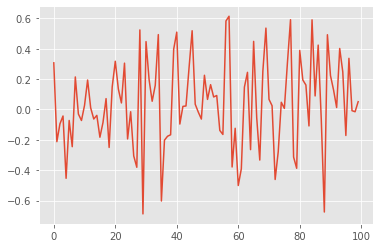

In [2]:
class StochVol(ssm.StateSpaceModel):
    def PX0(self):  # Distribution of X_0
        return dists.Normal(loc=self.mu, scale=self.sigma / np.sqrt(1. - self.rho**2))
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return dists.Normal(loc=self.mu + self.rho * (xp - self.mu), scale=self.sigma)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        return dists.Normal(loc=0., scale=np.exp(x))
   
my_model = StochVol(mu=-1., rho=.9, sigma=.1)  # actual model
true_states, data = my_model.simulate(100)  # we simulate from the model 100 data points

plt.style.use('ggplot')
plt.figure()
plt.plot(data)

Methods `PX0`, `PX` and `PY` return objects that represent probability distributions (defined in module `distributions`. Parameters $\mu$, $\rho$ and $\sigma$ are defined as **attributes** of a class instance: i.e. `self.mu` and so on. (`self` is the generic name for an instance of a class in Python.)

If your are not very familiar with OOP (object oriented programming) and related concepts (classes, instances, etc.), here is a simple way to understand them in our context: 

* The **class** `StochVol` represents the parametric class of stochastic volatility models.

* The object `my_model` (a **class instance** of `StochVol`) defines a particular model, where parameters $\mu$, $\rho$ and $\sigma$ are fixed to certain values. 

In particular, we can inspect the attributes of `my_model` that store the parameter values. 

In [3]:
my_model.mu, my_model.rho, my_model.sigma

(-1.0, 0.9, 0.1)

Class `StochVol` is a sub-class of ``StateSpaceModel``. (You can see that from the first line of its definition.) For instance, it inherits a method called `simulate` that generates states and datapoints from the considered model.  

## Particle filtering

There are several particle algorithms that one may associate to a given state-space model. Here we consider the simplest option: the **bootstrap filter**. (See next tutorial for how to implement a guided or auxiliary filter.) The code below runs such a bootstrap filter for $N=100$ particles, using stratified resampling.

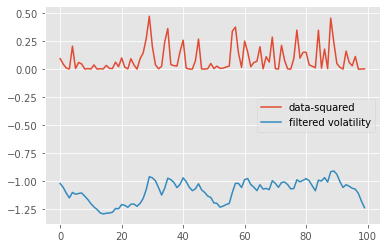

In [4]:
fk_model = ssm.Bootstrap(ssm=my_model, data=data)  # we use the Bootstrap filter
pf = particles.SMC(fk=fk_model, N=100, resampling='stratified', 
                   collect=[Moments()], store_history=True)  # the algorithm
pf.run()  # actual computation

# plot
plt.figure()
plt.plot([yt**2 for yt in data], label='data-squared')
plt.plot([m['mean'] for m in pf.summaries.moments], label='filtered volatility')
plt.legend()

Recall that a particle filter is a Monte Carlo algorithm: each execution returns a random, slightly different result. Thus, it is useful to run a particle filter multiple times to assess how stable are the results. Say, for instance, that we would like to compare the variability of the log-likelihood estimate provided by a particle filter, when either a standard Monte Carlo algorithm is used, or its QMC variant, called SQMC. The following command runs 30 times each of these two algorithms.

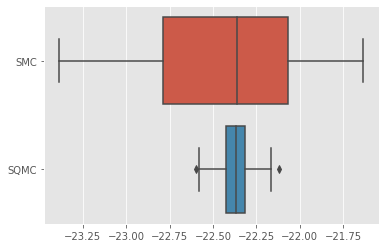

In [5]:
results = particles.multiSMC(fk=fk_model, N=100, nruns=30, qmc={'SMC':False, 'SQMC':True})
plt.figure()
sb.boxplot(x=[r['output'].logLt for r in results], y=[r['qmc'] for r in results]);

As expected, the variance of SQMC estimates is quite lower. 

Command `multiSMC` makes it possible to run several particle filters, with varying options. Parallel execution is also possible, as explained in next tutorial.

## Smoothing

So far, we have only considered filtering; let's try smoothing, that is, approximating the distribution of the whole trajectory $X_{0:T}$, given data $Y_{0:T}=y_{0:T}$, for some fixed time horizon $T=100$. In particular, we are going to sample smoothing trajectories from the output of the first particle filter we ran a few steps above.

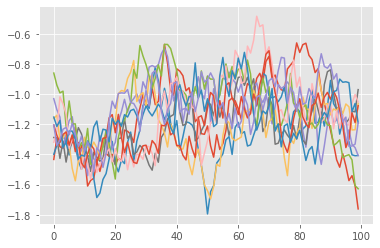

In [6]:
smooth_trajectories = pf.hist.backward_sampling(10) 
plt.figure()
plt.plot(smooth_trajectories);

Here, we used the standard version of the FFBS (forward filtering, backward sampling) algorithm, which generates smoothing trajectories from the particle **history** (which we generated when running pf above). Other smoothing algorithms are available, see the next tutorial.

## (Bayesian) Parameter estimation

Finally, we consider how to estimate the parameter $\theta=(\alpha, \rho, \sigma)$ from a given data-set. First, we set up a prior as follows.

In [7]:
prior_dict = {'mu':dists.Normal(), 
              'sigma': dists.Gamma(a=1., b=1.), 
              'rho':dists.Beta(9., 1.)}
my_prior = dists.StructDist(prior_dict)

Again, the code above should be fairly readable: the prior for $\mu$ is $N(0,1)$, the one for $\sigma$ is a Gamma(1,1) and so on. 
(As before, probability distributions are represented by objects defined in the `distributions` module.)

This may not be a sensible prior distribution; for instance  it restricts $\rho$ to $[0,1]$. However, this will suffice for our purposes. 
A popular way to simulate from the posterior distribution of the parameters of a state-space model is PMMH, a particular instance of the PMMC framework. Basically, this is a MCMC algorithm that runs at each iteration a particle filter so as to evaluate the likelihood. 


In [8]:
%%capture
from particles import mcmc  # where the MCMC algorithms (PMMH, Particle Gibbs, etc) live
pmmh = mcmc.PMMH(ssm_cls=StochVol, prior=my_prior, data=data, Nx=50, niter = 1000)
pmmh.run()  # Warning: takes a few seconds

Again, the code above is hopefully readable: PMMH is run for 1000 iterations (`niter`), the particle filter run at each iteration have $N_x=50$ particles, and so on. One point worth mentioning is that we pass as an argument the *class* `StochVol`. Again, remember that this class indeed represents the considered parametric class (as opposed to `my_model`, which was a stochastic volatility model, for certain fixed parameter values). 

OK, we have waited long enough, let's plot the results.

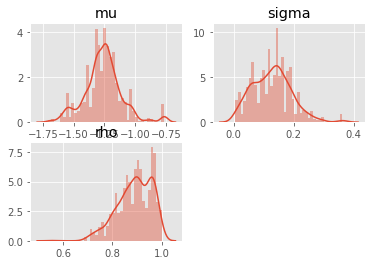

In [9]:
# plot the marginals 
burnin = 100  # discard the 100 first iterations
for i, param in enumerate(prior_dict.keys()):
    plt.subplot(2, 2, i+1)
    sb.distplot(pmmh.chain.theta[param][burnin:], 40)
    plt.title(param)

These results might not be very reliable, given that we used a fairly small number of MCMC iterations. If you are familiar with MCMC, you may wonder how the Metropolis proposal was set: by default, PMMH uses an adaptive Gaussian random walk proposal, such that the covariance matrix of the random step is iteratively adapted to the running simulation. 

The library also implements SMC$^2$, and Particle Gibbs, but that will be covered in the next tutorial.


## The end

That's all, folks! This very basic tutorial is over. If you crave for more, head to the other tutorials: 

* [Advanced tutorial for state-space models](advanced_tutorial_ssm.html): covers the same topics as above (filtering, smoothing, parameter estimation for state-space models) but with more details.
* [Tutorial on Bayesian estimation](Bayes_estimation_ssm.html): covers PMCMC and SMC^2 algorithms that may be used to estimate the parameters of a state-space model. 
* [Tutorial on SMC samplers](SMC_samplers_tutorial.html): a tutorial on how to run a SMC sampler (such as IBIS or tempering SMC) for a given static target distribution. 
* [How  to define manually Feynman-Kac models](Defining_Feynman-Kac_models_manually.html): an advanced tutorial on how to define your own Feynman-Kac models.

